In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
# fit a logistic regression model on an imbalanced classification dataset
from sklearn.metrics import r2_score, roc_auc_score, recall_score, precision_score, accuracy_score, mean_squared_error, auc, roc_curve
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import scipy.stats as st
from joblib import dump, load
import pickle
import csv
import random
from matplotlib.transforms import Affine2D
from imblearn.over_sampling import SMOTE, ADASYN
import dimod
import json
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from copy import deepcopy

In [54]:
df_all = pd.read_csv("data/full_dataset.csv",header=0, sep="\,").fillna(method = "ffill")


target_f = 'Graft loss 1 year'

mandatory_f = [
    'AKI - KDIGO 2012',
    'FSGS',
    'Reduction to steroid only',
    'Transfusion [YES/NO]',
]

with open("data/16.json") as file:
    miqubo_result = dimod.SampleSet.from_serializable(json.load(file))
    miqubo_f = [x for x, y in miqubo_result.first.sample.items() if y ==1]

miqubo_f = list(set(miqubo_f) - set(mandatory_f) - set(target_f))
assert sum(df_all.isna().sum())==0, "Still nan entries in dataset"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


# Title


__abs__

In [55]:
def train_on_k_features(model, df, target_f, mandatory_f, free_f, k, repetitions = 10, sample = True):
    #print("aaaaa" + str(len(df.columns)))    
    threashold = 0.9
    df_ = deepcopy(df)
    y_train_pre = df.pop(target_f)

    # define evaluation procedure
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    results = {}
    results["roc"] = []
    results["recall"] = []
    results["precission"] = []
    results["accurarcy"] = []
    results["mse"] = []
    results["r2"] = []

    for _ in range(repetitions):
        features = mandatory_f  + random.sample(set(free_f), k) #random.choices(free_f, k = k)
        #print(features)
        x_train, x_test, y_train, y_test = train_test_split(df_[features], y_train_pre, test_size=0.2, random_state=42, shuffle=True)
        # find out how cross_val_score works
        # scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
        model_ = deepcopy(model)
        model_.fit(x_train, y_train)
        # discretize predictions
        y_pred = np.where(model_.predict(x_test)>threashold,1, 0)

        results["roc"].append(roc_auc_score(y_test, y_pred))
        results["recall"].append(recall_score(y_test, y_pred))
        results["precission"].append(precision_score(y_test, y_pred))
        results["accurarcy"].append(accuracy_score(y_test, y_pred))
        results["mse"].append(mean_squared_error(y_test, y_pred))
        results["r2"].append(r2_score(y_test, y_pred))

    stat_results = {}
    for key in results.keys():
        stat_results[key+"_mean"] = np.mean(results[key])
        stat_results[key+"_std"] = np.std(results[key])
    
    return stat_results

def train_on_range_features(model, df, target_f, mandatory_f, free_f, range, repetitions = 10, sample = True):
    df_ = deepcopy(df)
    n_f = 1 + len(mandatory_f)
    stat_res = {}

    naming_map = {x[1] : "f_{}".format(x[0]) for x in enumerate(df_.columns)}
    df_ = df_.rename(columns=naming_map)
    target_f_ = naming_map[target_f]
    mandatory_f_ = [naming_map[x] for x in mandatory_f]
    free_f_ = [naming_map[x] for x in free_f]
    if sample:
        y_train = df_.pop(target_f_)
        x_train = df_
        df_post_data, df_post_labels = SMOTE().fit_resample(x_train, y_train)
        df_post_data.insert(0, target_f_, df_post_labels)
    #print(type(df_post_data.copy()))
    #print(df_post_data.copy())
    for i in range:
        
        stat_res[n_f+i] = train_on_k_features(deepcopy(model), deepcopy(df_post_data), target_f_, mandatory_f_, free_f_, i, repetitions)

    return stat_res


In [73]:
df_ = deepcopy(df_all)
naming_map_ = {x[1] : "f_{}".format(x[0]) for x in enumerate(df_.columns)}

df_ = df_.rename(columns=naming_map_)
target_f_ = naming_map_[target_f]
mandatory_f_ = [naming_map_[x] for x in mandatory_f]
free_f_miqubo_ = [naming_map_[x] for x in miqubo_f]
free_f_all_ = list(set(naming_map_.values()) - set(mandatory_f_) - set(target_f_))
y_train = df_.pop(target_f_)
x_train = df_
df_post_data, df_post_labels = SMOTE().fit_resample(x_train, y_train)
df_post_data.insert(0, target_f_, df_post_labels)

stat_miqubo = {}
stat_all = {}
model_tmp = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1) #KNeighborsClassifier(3) #AdaBoostClassifier() #KNeighborsClassifier(3) #AdaBoostClassifier()#LogisticRegression(solver='lbfgs')
repetitions = 5

for i in np.arange(len(free_f_miqubo_)+1):
    print(i)
    miqubo_df_ = df_post_data[[target_f_] + free_f_miqubo_ + mandatory_f_]
    stat_miqubo[i] = train_on_k_features(deepcopy(model_tmp), deepcopy(miqubo_df_), target_f_, mandatory_f_, free_f_miqubo_, i, repetitions)
    stat_all[i] = train_on_k_features(deepcopy(model_tmp), deepcopy(df_post_data), target_f_, mandatory_f_, free_f_all_, i, repetitions)


0
1
2
3
4
5
6
7
8
9
10
11
12


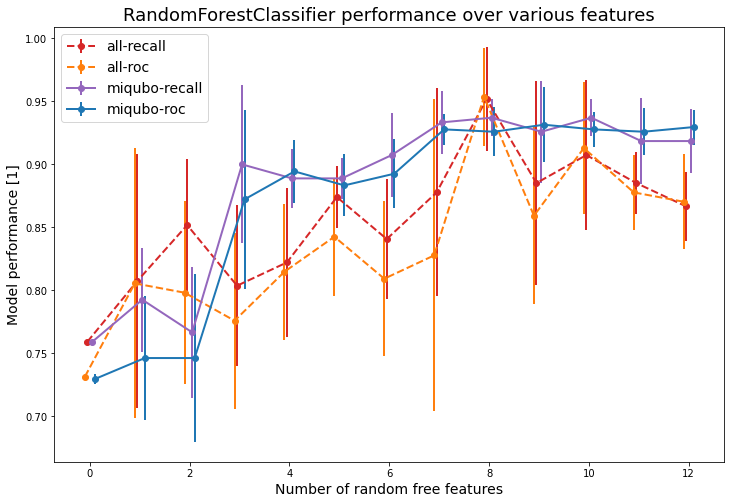

In [75]:
miqubo_series = {metric_key:[y[metric_key] for _, y in  stat_miqubo.items()] for metric_key in stat_miqubo[list(stat_miqubo.keys())[0]].keys()}
all_series = {metric_key:[y[metric_key] for _, y in  stat_all.items()] for metric_key in stat_all[list(stat_all.keys())[0]].keys()}

fig, ax = plt.subplots(figsize = (12,8))

trans1 = Affine2D().translate(-0.05, 0.0) + ax.transData
trans2 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans3 = Affine2D().translate(+0.05, 0.0) + ax.transData
trans4 = Affine2D().translate(+0.1, 0.0) + ax.transData

x_ = np.arange(len(miqubo_f)+1)

ax.errorbar(
        x_, 
        all_series["recall_mean"], 
        yerr = all_series["recall_std"], 
        label = "all-recall",
        color='tab:red',
        linewidth = 2,
        marker="o",
        transform=trans1,
        ls = '--')

ax.errorbar(
        x_, 
        all_series["roc_mean"], 
        yerr = all_series["roc_std"], 
        label = "all-roc",
        color='tab:orange',
        linewidth = 2,
        marker="o",
        transform=trans2,
        ls = '--')

ax.errorbar(
        x_, 
        miqubo_series["recall_mean"], 
        yerr = miqubo_series["recall_std"], 
        label = "miqubo-recall",
        color='tab:purple',
        linewidth = 2,
        marker="o",
        transform=trans3,
        ls = '-')

ax.errorbar(
        x_, 
        miqubo_series["roc_mean"], 
        yerr = miqubo_series["roc_std"], 
        label = "miqubo-roc",
        color='tab:blue',
        linewidth = 2,
        marker="o",
        transform=trans4,
        ls = '-')

plt.legend(loc ='upper left', fontsize = 14)
 
plt.title('RandomForestClassifier performance over various features',  fontsize = 18)
plt.xlabel('Number of random free features',  fontsize = 14)
plt.ylabel("Model performance [1]",  fontsize = 14)
#plt.savefig("plots/general/KNeighborsClassifier_performance_over_all_features.png")
plt.show()

In [15]:
model_tmp = AdaBoostClassifier()#LogisticRegression(solver='lbfgs')
model_1 = deepcopy(model_tmp)

all_remaining = list(set(df_all.columns) - set(mandatory_f) - set([target_f]))
all_stat = train_on_range_features(deepcopy(model_tmp), deepcopy(df_all), target_f, mandatory_f,all_remaining, [0], 3)

miqubo_df = deepcopy(df_all[[target_f] + mandatory_f + miqubo_f])
miqubo_stat = train_on_range_features(deepcopy(model_tmp), deepcopy(miqubo_df), target_f, mandatory_f,miqubo_f, [0], 3)

aaaaa152
aaaaa17


In [16]:
print(miqubo_stat)
print(all_stat)

{5: {'roc_mean': 0.6666666666666666, 'roc_std': 1.1102230246251565e-16, 'recall_mean': 0.6296296296296297, 'recall_std': 0.0, 'precission_mean': 0.68, 'precission_std': 0.0, 'accurarcy_mean': 0.6666666666666666, 'accurarcy_std': 0.0, 'mse_mean': 0.3333333333333333, 'mse_std': 0.0, 'r2_mean': -0.33333333333333326, 'r2_std': 0.0}}
{5: {'roc_mean': 0.7129629629629631, 'roc_std': 1.1102230246251565e-16, 'recall_mean': 0.7222222222222222, 'recall_std': 0.0, 'precission_mean': 0.7090909090909091, 'precission_std': 0.0, 'accurarcy_mean': 0.7129629629629629, 'accurarcy_std': 0.0, 'mse_mean': 0.28703703703703703, 'mse_std': 0.0, 'r2_mean': -0.14814814814814814, 'r2_std': 0.0}}


In [76]:
binary_f = [x for x in df_all.columns if len(np.unique(df_all[x]))==2]
float_f = list(set([x for x, y in df_all.dtypes.items() if y == np.float]) - set(binary_f))
int_f = list(set([x for x, y in df_all.dtypes.items() if y == np.int]) - set(binary_f))

df_float_norm = pd.DataFrame(data=preprocessing.StandardScaler().fit(df_all[float_f]).transform(df_all[float_f]), columns=float_f)
df_int_norm = pd.DataFrame(data=preprocessing.StandardScaler().fit(df_all[int_f]).transform(df_all[int_f]), columns=int_f)
df_normalized = pd.concat([df_all[binary_f], df_float_norm, df_int_norm], axis=1, join="inner")


In [101]:
df_ = deepcopy(df_normalized)
naming_map_ = {x[1] : "f_{}".format(x[0]) for x in enumerate(df_.columns)}

df_ = df_.rename(columns=naming_map_)
target_f_ = naming_map_[target_f]
mandatory_f_ = [naming_map_[x] for x in mandatory_f]
free_f_miqubo_ = [naming_map_[x] for x in miqubo_f]
free_f_all_ = list(set(naming_map_.values()) - set(mandatory_f_) - set(target_f_))
y_train = df_.pop(target_f_)
x_train = df_
df_post_data, df_post_labels = SMOTE().fit_resample(x_train, y_train)
df_post_data.insert(0, target_f_, df_post_labels)

stat_miqubo = {}
stat_all = {}
model_tmp = DecisionTreeClassifier(max_depth=5) #LogisticRegression(solver='lbfgs') # KNeighborsClassifier(3) #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1) # #AdaBoostClassifier() #KNeighborsClassifier(3) #AdaBoostClassifier()#LogisticRegression(solver='lbfgs')
repetitions = 10

for i in np.arange(len(free_f_miqubo_)+1):
    print(i)
    miqubo_df_ = df_post_data[[target_f_] + free_f_miqubo_ + mandatory_f_]
    stat_miqubo[i] = train_on_k_features(deepcopy(model_tmp), deepcopy(miqubo_df_), target_f_, mandatory_f_, free_f_miqubo_, i, repetitions)
    stat_all[i] = train_on_k_features(deepcopy(model_tmp), deepcopy(df_post_data), target_f_, mandatory_f_, free_f_all_, i, repetitions)


0
1
2
3
4
5
6
7
8
9
10
11
12


In [106]:

#lasso = linear_model.Lasso(alpha=alpha, normalize = False)
#enet = linear_model.ElasticNet(alpha=alpha, l1_ratio=0.7, normalize = False)
#logr = LogisticRegression(solver='lbfgs', class_weight=weights)

names = ["Lasso", "Enet", "Loger", "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
        "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
        "Naive Bayes", "QDA"]
alpha = 0.01
models = [
    linear_model.Lasso(alpha=alpha, normalize = False),
    linear_model.ElasticNet(alpha=alpha, l1_ratio=0.7, normalize = False),
    LogisticRegression(solver='lbfgs'),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]



In [104]:
def various_f_over_models(models, models_names):

    df_ = deepcopy(df_normalized)
    naming_map_ = {x[1] : "f_{}".format(x[0]) for x in enumerate(df_.columns)}

    df_ = df_.rename(columns=naming_map_)
    target_f_ = naming_map_[target_f]
    mandatory_f_ = [naming_map_[x] for x in mandatory_f]
    free_f_miqubo_ = [naming_map_[x] for x in miqubo_f]
    free_f_all_ = list(set(naming_map_.values()) - set(mandatory_f_) - set(target_f_))
    y_train = df_.pop(target_f_)
    x_train = df_
    df_post_data, df_post_labels = SMOTE().fit_resample(x_train, y_train)
    df_post_data.insert(0, target_f_, df_post_labels)

    for model, model_name in zip(models, models_names):

        stat_miqubo = {}
        stat_all = {}
        model_tmp = model #DecisionTreeClassifier(max_depth=5) #LogisticRegression(solver='lbfgs') # KNeighborsClassifier(3) #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1) # #AdaBoostClassifier() #KNeighborsClassifier(3) #AdaBoostClassifier()#LogisticRegression(solver='lbfgs')
        repetitions = 10

        for i in np.arange(len(free_f_miqubo_)+1):
            print(i)
            miqubo_df_ = df_post_data[[target_f_] + free_f_miqubo_ + mandatory_f_]
            stat_miqubo[i] = train_on_k_features(deepcopy(model_tmp), deepcopy(miqubo_df_), target_f_, mandatory_f_, free_f_miqubo_, i, repetitions)
            stat_all[i] = train_on_k_features(deepcopy(model_tmp), deepcopy(df_post_data), target_f_, mandatory_f_, free_f_all_, i, repetitions)

        #model_name = "DecisionTreeClassifier"
        miqubo_series = {metric_key:[y[metric_key] for _, y in  stat_miqubo.items()] for metric_key in stat_miqubo[list(stat_miqubo.keys())[0]].keys()}
        all_series = {metric_key:[y[metric_key] for _, y in  stat_all.items()] for metric_key in stat_all[list(stat_all.keys())[0]].keys()}

        a_file = open("models_evaluation/performance_over_various_features/{}-miqubo.pkl".format(model_name), "wb")
        pickle.dump(miqubo_series, a_file)
        a_file.close()

        a_file = open("models_evaluation/performance_over_various_features/{}-all.pkl".format(model_name), "wb")
        pickle.dump(miqubo_series, a_file)
        a_file.close()

        fig, ax = plt.subplots(figsize = (12,8))

        trans1 = Affine2D().translate(-0.05, 0.0) + ax.transData
        trans2 = Affine2D().translate(-0.1, 0.0) + ax.transData
        trans3 = Affine2D().translate(+0.05, 0.0) + ax.transData
        trans4 = Affine2D().translate(+0.1, 0.0) + ax.transData

        x_ = np.arange(len(miqubo_f)+1)

        ax.errorbar(
                x_, 
                all_series["recall_mean"], 
                yerr = all_series["recall_std"], 
                label = "all features: recall",
                color='tab:red',
                linewidth = 2,
                marker="o",
                transform=trans1,
                ls = '--')

        ax.errorbar(
                x_, 
                all_series["roc_mean"], 
                yerr = all_series["roc_std"], 
                label = "all features: roc",
                color='tab:orange',
                linewidth = 2,
                marker="o",
                transform=trans2,
                ls = '--')

        ax.errorbar(
                x_, 
                miqubo_series["recall_mean"], 
                yerr = miqubo_series["recall_std"], 
                label = "miqubo features: recall",
                color='tab:purple',
                linewidth = 2,
                marker="o",
                transform=trans3,
                ls = '-')

        ax.errorbar(
                x_, 
                miqubo_series["roc_mean"], 
                yerr = miqubo_series["roc_std"], 
                label = "miqubo features: roc",
                color='tab:blue',
                linewidth = 2,
                marker="o",
                transform=trans4,
                ls = '-')

        plt.legend(loc ='lower right', fontsize = 18)
        
        plt.title('{} over various features'.format(model_name),  fontsize = 26)
        plt.xlabel('Number of random free features',  fontsize = 18)
        plt.ylabel("Model performance [1]",  fontsize = 18)
        plt.savefig("plots/performance_over_various_features/{}_performance.png".format(model_name))
        plt.savefig("plots/performance_over_various_features/{}_performance.jpg".format(model_name))

        #plt.show()

0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

1


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

2


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

3


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

4


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

7


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

10


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11
12


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

1


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

2


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

3


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

4


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

7


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


2
3
4
5


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


6


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


7
8
9
10
11


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


12
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-

2


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)

3


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/usr/l

4


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-

5


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-

6


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pre

7


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


8


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


9


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/usr/l

10


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages

11


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/l

12


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/l

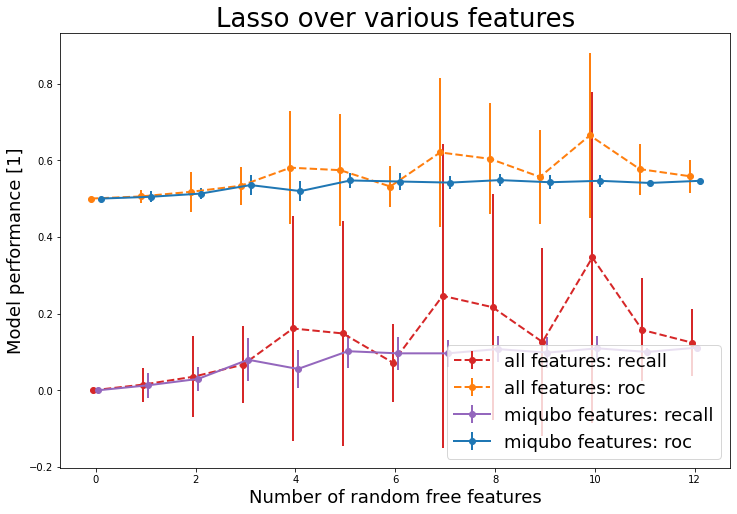

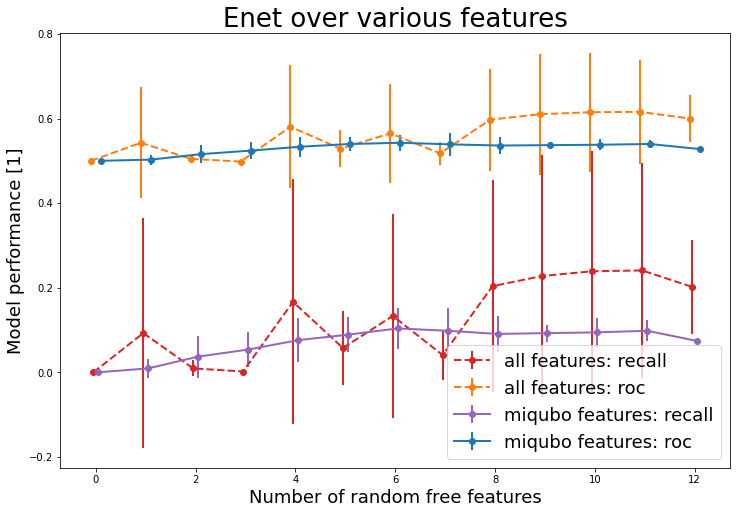

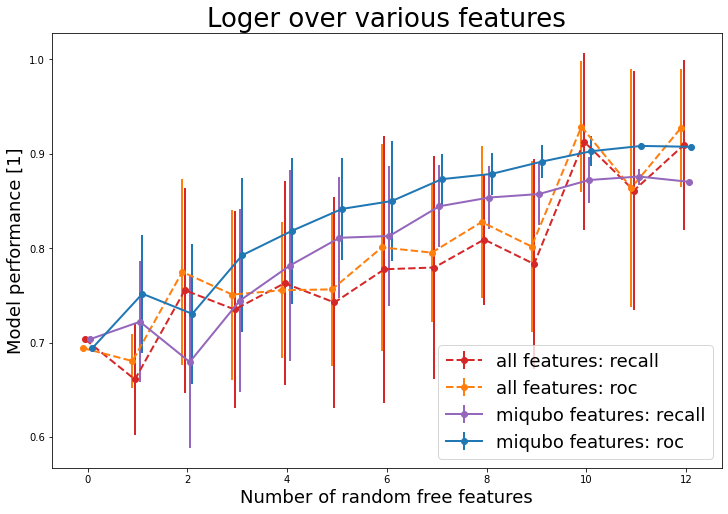

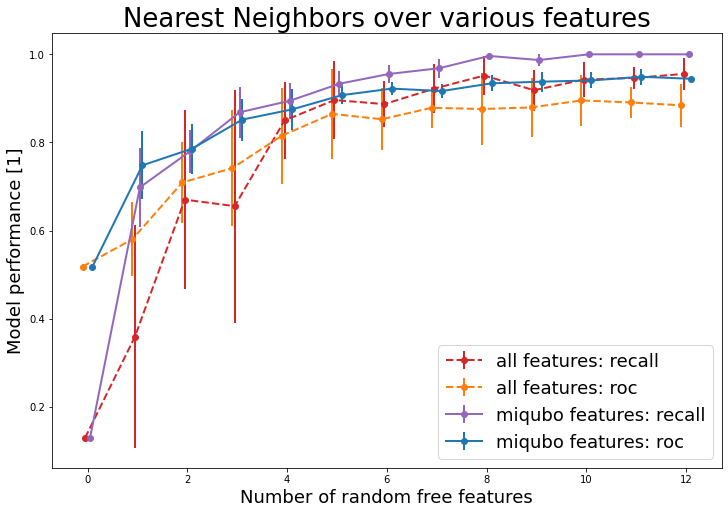

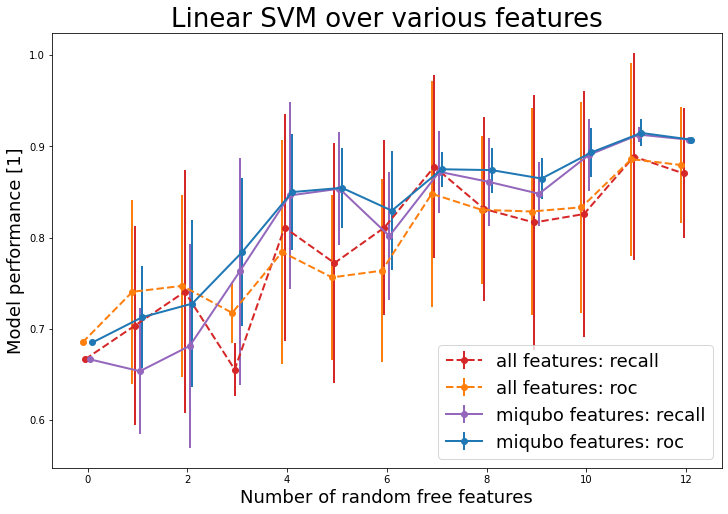

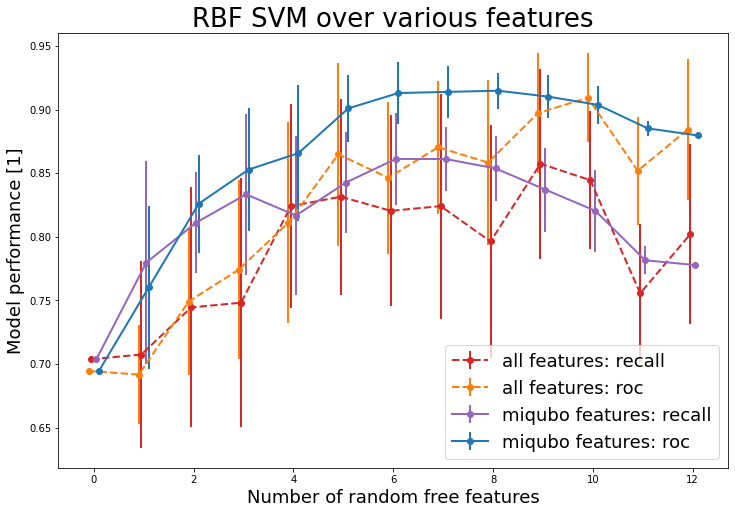

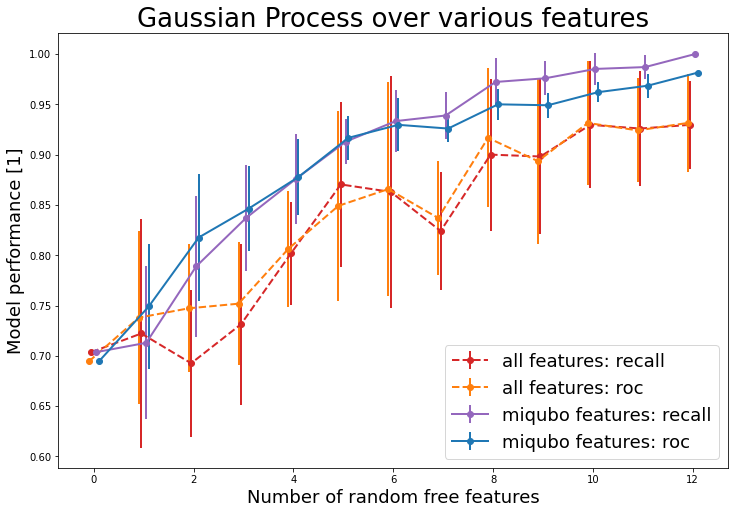

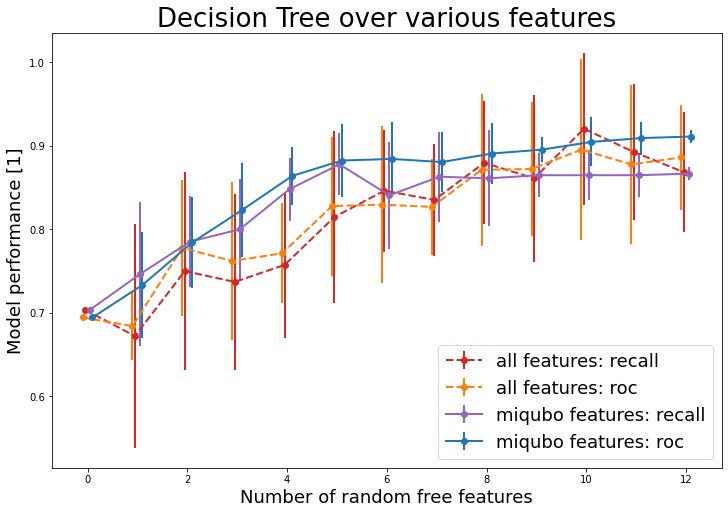

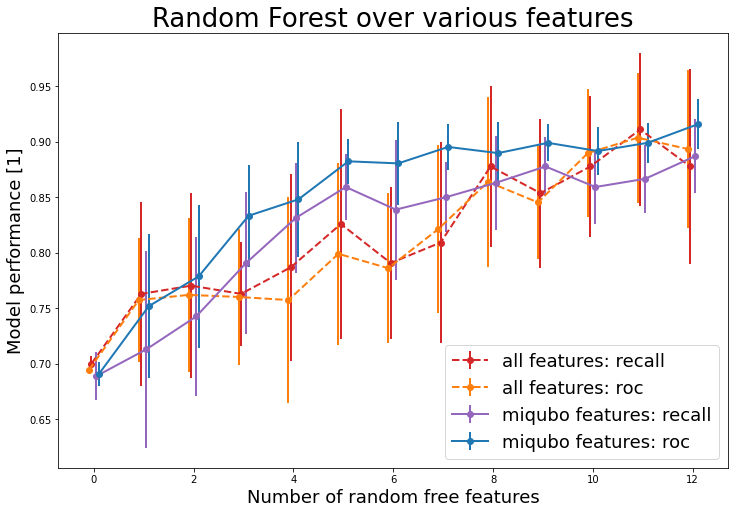

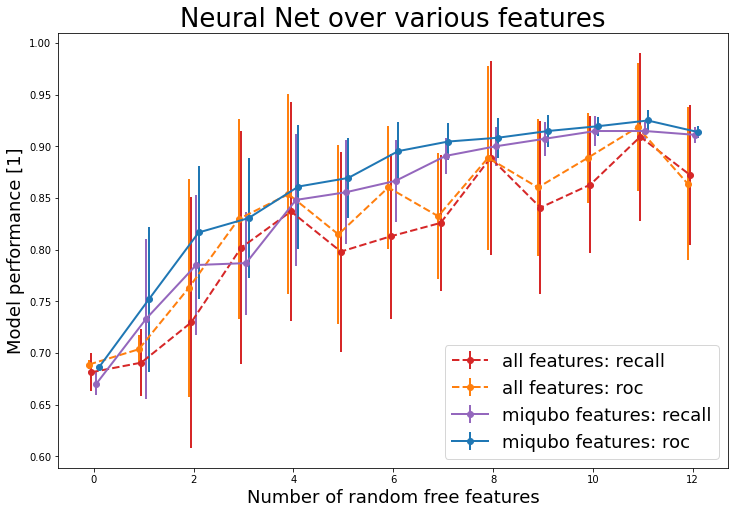

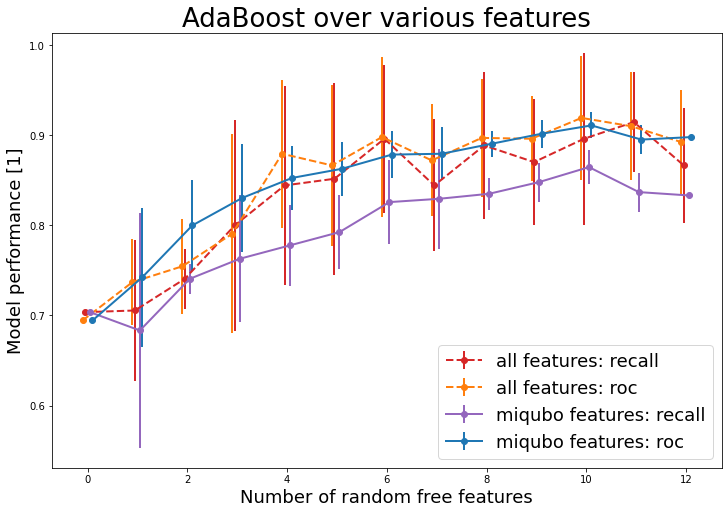

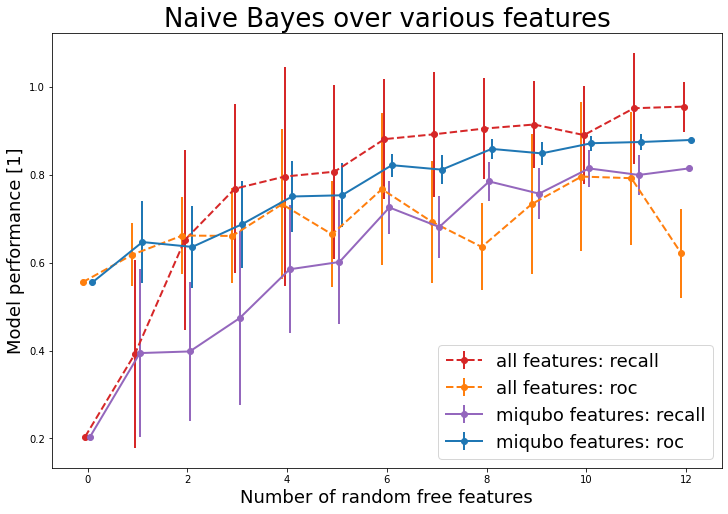

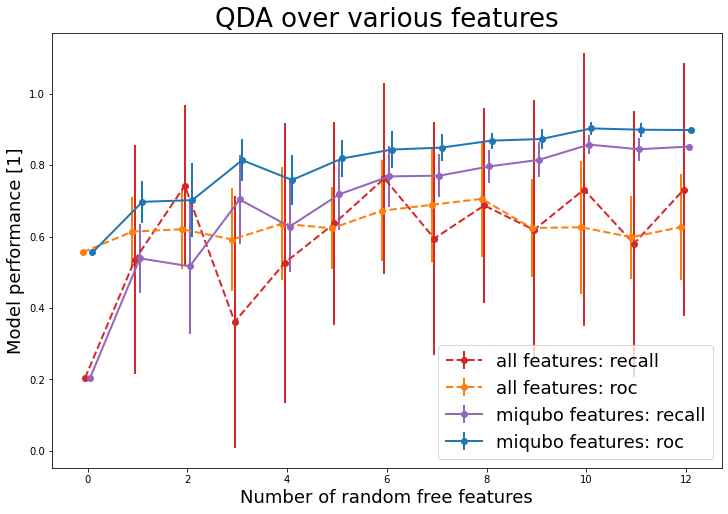

In [107]:
various_f_over_models(models, names)

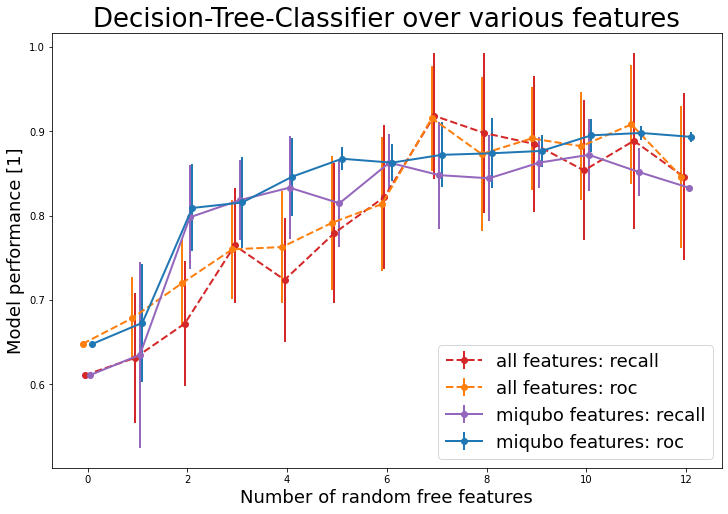

In [102]:
model_name = "DecisionTreeClassifier"
miqubo_series = {metric_key:[y[metric_key] for _, y in  stat_miqubo.items()] for metric_key in stat_miqubo[list(stat_miqubo.keys())[0]].keys()}
all_series = {metric_key:[y[metric_key] for _, y in  stat_all.items()] for metric_key in stat_all[list(stat_all.keys())[0]].keys()}

a_file = open("models_evaluation/performance_over_various_features/{}-miqubo.pkl".format(model_name), "wb")
pickle.dump(miqubo_series, a_file)
a_file.close()

a_file = open("models_evaluation/performance_over_various_features/{}-all.pkl".format(model_name), "wb")
pickle.dump(miqubo_series, a_file)
a_file.close()

fig, ax = plt.subplots(figsize = (12,8))

trans1 = Affine2D().translate(-0.05, 0.0) + ax.transData
trans2 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans3 = Affine2D().translate(+0.05, 0.0) + ax.transData
trans4 = Affine2D().translate(+0.1, 0.0) + ax.transData

x_ = np.arange(len(miqubo_f)+1)

ax.errorbar(
        x_, 
        all_series["recall_mean"], 
        yerr = all_series["recall_std"], 
        label = "all features: recall",
        color='tab:red',
        linewidth = 2,
        marker="o",
        transform=trans1,
        ls = '--')

ax.errorbar(
        x_, 
        all_series["roc_mean"], 
        yerr = all_series["roc_std"], 
        label = "all features: roc",
        color='tab:orange',
        linewidth = 2,
        marker="o",
        transform=trans2,
        ls = '--')

ax.errorbar(
        x_, 
        miqubo_series["recall_mean"], 
        yerr = miqubo_series["recall_std"], 
        label = "miqubo features: recall",
        color='tab:purple',
        linewidth = 2,
        marker="o",
        transform=trans3,
        ls = '-')

ax.errorbar(
        x_, 
        miqubo_series["roc_mean"], 
        yerr = miqubo_series["roc_std"], 
        label = "miqubo features: roc",
        color='tab:blue',
        linewidth = 2,
        marker="o",
        transform=trans4,
        ls = '-')

plt.legend(loc ='lower right', fontsize = 18)
 
plt.title('Decision-Tree-Classifier over various features',  fontsize = 26)
plt.xlabel('Number of random free features',  fontsize = 18)
plt.ylabel("Model performance [1]",  fontsize = 18)
plt.savefig("plots/performance_over_various_features/{}_performance.png".format(model_name))
plt.savefig("plots/performance_over_various_features/{}_performance.jpg".format(model_name))

plt.show()



In [83]:
miqubo_series


{'roc_mean': [0.6944444444444444,
  0.7185185185185186,
  0.7722222222222221,
  0.8722222222222221,
  0.874074074074074,
  0.8777777777777779,
  0.9111111111111111,
  0.9055555555555556,
  0.9296296296296296,
  0.9055555555555556,
  0.9444444444444443,
  0.9407407407407407,
  0.9444444444444444],
 'roc_std': [0.0,
  0.042471647930295314,
  0.042065987746668705,
  0.03628873693012115,
  0.019065981742568485,
  0.05118620355957498,
  0.019945054841238957,
  0.02579331162441505,
  0.017173367584251285,
  0.02298087712220526,
  0.013094570021973112,
  0.012559870339120923,
  0.0],
 'recall_mean': [0.7037037037037037,
  0.6888888888888889,
  0.737037037037037,
  0.8777777777777779,
  0.874074074074074,
  0.9407407407407407,
  0.9444444444444443,
  0.962962962962963,
  0.962962962962963,
  0.9703703703703704,
  0.9888888888888889,
  0.9925925925925926,
  1.0],
 'recall_std': [0.0,
  0.06869347033700524,
  0.05023948135648346,
  0.009072184232530275,
  0.013857990321384947,
  0.01814436846506

In [82]:
df_normalized

,Confirmed UTI,Urinary sepsis,HTN,DM,PAD,CAD,ACS,HF,AF,Stroke/TIA,...,Diastolic blood pressure,Age,WIT [min],AKI KDIGO 2012 - Stage [1/2/3],Blood transfusion in transfusion units,Length of stay [days],ASPAT [IU/l],AB - mismatch,ilość UTI 2014-2019,Charlston Comorbidity Index
0,1,1,1,0,0,0,0,0,0,0,...,0.965366,-1.234742,-0.271141,2.626059,-0.183477,-0.618020,-0.696955,-0.481714,-0.321858,-1.222226
1,1,1,1,1,1,1,1,0,0,0,...,0.030139,0.122454,-0.271141,1.528220,-0.183477,-0.489462,-0.669529,-0.481714,0.122542,1.394346
2,1,1,1,1,0,0,0,0,0,0,...,0.217184,-1.591898,-0.271141,-0.667457,-0.183477,-0.746579,-0.669529,-0.481714,2.788946,-0.698912
3,1,1,1,0,0,0,0,0,0,0,...,0.965366,1.336786,-0.034214,0.430382,-0.183477,-0.296624,-0.706928,-0.481714,1.011344,0.347717
4,1,0,1,0,0,1,1,0,0,1,...,-0.905089,0.408179,-0.073702,-0.667457,-0.183477,-0.682299,-0.507467,0.511409,-0.321858,0.347717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0,0,1,0,0,0,0,0,0,0,...,0.030139,0.336748,-0.136882,-0.667457,-0.183477,-0.103786,-0.709422,0.511409,-0.766259,-0.175597
297,0,0,1,0,0,0,0,0,0,0,...,0.030139,0.193885,0.005274,-0.667457,-0.183477,-0.103786,-0.709422,-0.481714,-0.766259,-0.175597
298,0,0,1,1,0,1,0,0,1,0,...,1.900594,-0.163272,0.005274,-0.667457,-0.183477,-0.103786,-0.709422,-0.481714,-0.766259,-0.175597
299,0,0,1,1,0,1,0,0,0,0,...,0.965366,0.193885,-0.073702,-0.667457,-0.183477,-0.103786,-0.709422,-0.481714,-0.766259,-0.175597
